# Task Solving with Code Generation, Execution and Debugging

In this notebook, we demonstrate how to use `AssistantAgent` and `UserProxyAgent` to write code and execute the code. Here `AssistantAgent` is an LLM-based agent that can write Python code (in a Python coding block) for a user to execute for a given task. `UserProxyAgent` is an agent which serves as a proxy for the human user to execute the code written by `AssistantAgent`, or automatically execute the code. Depending on the setting of `human_input_mode` and `max_consecutive_auto_reply`, the `UserProxyAgent` either solicits feedback from the human user or returns auto-feedback based on the result of code execution (success or failure and corresponding outputs) to `AssistantAgent`. `AssistantAgent` will debug the code and suggest new code if the result contains error. The two agents keep communicating to each other until the task is done.

````{=mdx}
:::info Requirements
Install the following packages before running the code below:
```bash
pip install pyautogen matplotlib yfinance
```

For more information, please refer to the [installation guide](/docs/installation/).
:::
````

In [1]:
!pip install pyautogen matplotlib yfinance

In [5]:
from IPython.display import Image, display
import os
import autogen
from autogen.coding import LocalCommandLineCodeExecutor
from dotenv import load_dotenv  # <-- Importar

# Cargar las variables del archivo .env
load_dotenv()

# When using a single openai endpoint, you can use the following:
config_list = [{"model": "gpt-4.1", "api_key": os.getenv("OPENAI_API_KEY")}]

## Example Task: Check Stock Price Change

In the example below, let's see how to use the agents in AutoGen to write a python script and execute the script. This process involves constructing a `AssistantAgent` to serve as the assistant, along with a `UserProxyAgent` that acts as a proxy for the human user. In this example demonstrated below, when constructing the `UserProxyAgent`,  we select the `human_input_mode` to "NEVER". This means that the `UserProxyAgent` will not solicit feedback from the human user. It stops replying when the limit defined by `max_consecutive_auto_reply` is reached, or when `is_termination_msg()` returns true for the received message.

In [6]:
# create an AssistantAgent named "assistant"
assistant = autogen.AssistantAgent(
    name="assistant",
    llm_config={
        "cache_seed": 41,  # seed for caching and reproducibility
        "config_list": config_list,  # a list of OpenAI API configurations
        "temperature": 0,  # temperature for sampling
    },  # configuration for autogen's enhanced inference API which is compatible with OpenAI API
)

# create a UserProxyAgent instance named "user_proxy"
user_proxy = autogen.UserProxyAgent(
    name="user_proxy",
    human_input_mode="NEVER",
    max_consecutive_auto_reply=10,
    is_termination_msg=lambda x: x.get("content", "").rstrip().endswith("TERMINATE"),
    code_execution_config={
        # the executor to run the generated code
        "executor": LocalCommandLineCodeExecutor(work_dir="coding"),
    },
)
# the assistant receives a message from the user_proxy, which contains the task description
chat_res = user_proxy.initiate_chat(
    assistant,
    message="""What date is today? Compare the year-to-date gain for META and TESLA.""",
    summary_method="reflection_with_llm",
)

user_proxy (to assistant):

What date is today? Compare the year-to-date gain for META and TESLA.

--------------------------------------------------------------------------------
assistant (to user_proxy):

Plan:
1. Use Python to get today’s date.
2. Use Python to fetch the year-to-date (YTD) price data for META and TSLA (Tesla) from a financial API (e.g., Yahoo Finance).
3. Calculate and print the YTD gain for both stocks.

Let's start by getting today's date and fetching the required stock data.

```python
# filename: ytd_gain_meta_tsla.py
import datetime
import yfinance as yf

# Step 1: Get today's date
today = datetime.date.today()
print(f"Today's date: {today}")

# Step 2: Get the first trading day of the year
year_start = datetime.date(today.year, 1, 1)

# Step 3: Download historical data for META and TSLA
meta = yf.Ticker("META")
tsla = yf.Ticker("TSLA")

meta_hist = meta.history(start=year_start, end=today + datetime.timedelta(days=1))
tsla_hist = tsla.history(start=year_start

The example above involves code execution. In AutoGen, code execution is triggered automatically by the `UserProxyAgent` when it detects an executable code block in a received message and no human user input is provided. 
Users have the option to specify a different working directory by setting the `work_dir` argument when constructing a new instance of the `LocalCommandLineCodeExecutor`.
For Docker-based or Jupyter kernel-based code execution, please refer to 
[Code Executors Tutorial](/docs/tutorial/code-executors) for more information.

#### Check chat results
The `initiate_chat` method returns a `ChatResult` object, which is a dataclass object storing information about the chat. Currently, it includes the following attributes:

- `chat_history`: a list of chat history.
- `summary`: a string of chat summary. A summary is only available if a summary_method is provided when initiating the chat.
- `cost`: a tuple of (total_cost, total_actual_cost), where total_cost is a dictionary of cost information, and total_actual_cost is a dictionary of information on the actual incurred cost with cache.
- `human_input`: a list of strings of human inputs solicited during the chat. (Note that since we are setting `human_input_mode` to `NEVER` in this notebook, this list is always empty.)

In [7]:
print("Chat history:", chat_res.chat_history)

print("Summary:", chat_res.summary)
print("Cost info:", chat_res.cost)

Chat history: [{'content': 'What date is today? Compare the year-to-date gain for META and TESLA.', 'role': 'assistant', 'name': 'user_proxy'}, {'content': 'Plan:\n1. Use Python to get today’s date.\n2. Use Python to fetch the year-to-date (YTD) price data for META and TSLA (Tesla) from a financial API (e.g., Yahoo Finance).\n3. Calculate and print the YTD gain for both stocks.\n\nLet\'s start by getting today\'s date and fetching the required stock data.\n\n```python\n# filename: ytd_gain_meta_tsla.py\nimport datetime\nimport yfinance as yf\n\n# Step 1: Get today\'s date\ntoday = datetime.date.today()\nprint(f"Today\'s date: {today}")\n\n# Step 2: Get the first trading day of the year\nyear_start = datetime.date(today.year, 1, 1)\n\n# Step 3: Download historical data for META and TSLA\nmeta = yf.Ticker("META")\ntsla = yf.Ticker("TSLA")\n\nmeta_hist = meta.history(start=year_start, end=today + datetime.timedelta(days=1))\ntsla_hist = tsla.history(start=year_start, end=today + datetime.

## Example Task: Plot Chart

In [8]:
# followup of the previous question
user_proxy.send(
    recipient=assistant,
    message="""Plot a chart of their stock price change YTD. Save the data to stock_price_ytd.csv, and save the plot to stock_price_ytd.png.""",
)

user_proxy (to assistant):

Plot a chart of their stock price change YTD. Save the data to stock_price_ytd.csv, and save the plot to stock_price_ytd.png.

--------------------------------------------------------------------------------
assistant (to user_proxy):

Plan:
1. Use Python to fetch the YTD historical closing prices for META and TSLA.
2. Save the data to stock_price_ytd.csv.
3. Plot both stocks’ closing prices on a single chart, label clearly, and save as stock_price_ytd.png.

Here is the complete code:

```python
# filename: plot_stock_price_ytd.py
import datetime
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Get today's date and year start
today = datetime.date.today()
year_start = datetime.date(today.year, 1, 1)

# Step 2: Download historical data for META and TSLA
meta = yf.Ticker("META")
tsla = yf.Ticker("TSLA")

meta_hist = meta.history(start=year_start, end=today + datetime.timedelta(days=1))
tsla_hist = tsla.history(start=year_sta

Let's display the generated figure.

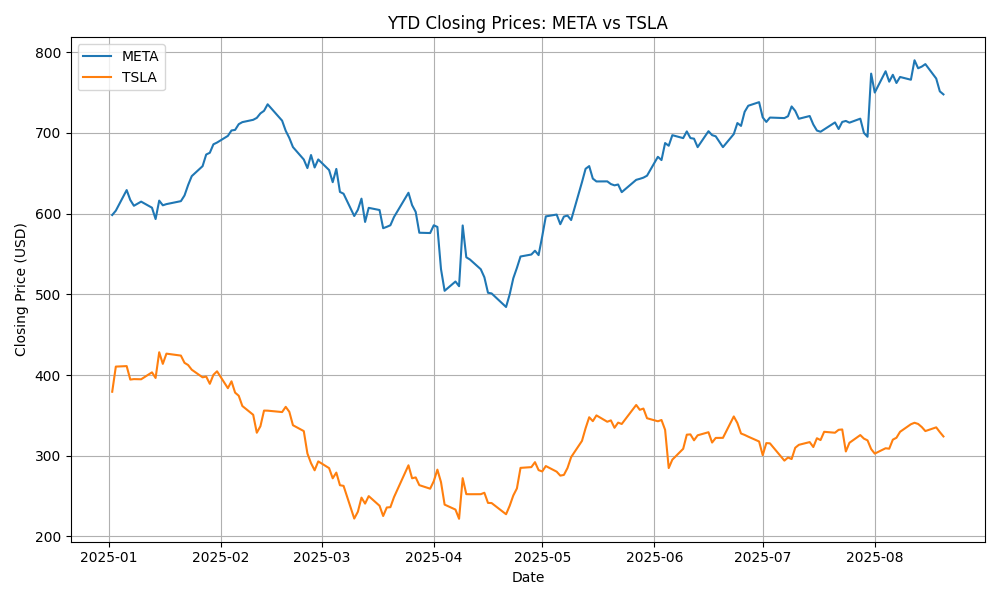

In [9]:
try:
    image = Image(filename="coding/stock_price_ytd.png")
    display(image)
except FileNotFoundError:
    print("Image not found. Please check the file name and modify if necessary.")

Let's display the raw data collected and saved from previous chat as well.

In [10]:
# Path to your CSV file
file_path = "coding/stock_price_ytd.csv"
try:
    with open(file_path, mode="r", encoding="utf-8") as file:
        # Read each line in the file
        for line in file:
            # Split the line into a list using the comma as a separator
            row = line.strip().split(",")
            # Print the list representing the current row
            print(row)
except FileNotFoundError:
    print("File not found. Please check the file name and modify if necessary.")

['Date', 'META_Close', 'TSLA_Close']
['2025-01-02 00:00:00-05:00', '598.2470092773438', '379.2799987792969']
['2025-01-03 00:00:00-05:00', '603.6280517578125', '410.44000244140625']
['2025-01-06 00:00:00-05:00', '629.15576171875', '411.04998779296875']
['2025-01-07 00:00:00-05:00', '616.8661499023438', '394.3599853515625']
['2025-01-08 00:00:00-05:00', '609.7080078125', '394.94000244140625']
['2025-01-10 00:00:00-05:00', '614.8394775390625', '394.739990234375']
['2025-01-13 00:00:00-05:00', '607.322021484375', '403.30999755859375']
['2025-01-14 00:00:00-05:00', '593.2653198242188', '396.3599853515625']
['2025-01-15 00:00:00-05:00', '616.097412109375', '428.2200012207031']
['2025-01-16 00:00:00-05:00', '610.2869873046875', '413.82000732421875']
['2025-01-17 00:00:00-05:00', '611.754638671875', '426.5']
['2025-01-21 00:00:00-05:00', '615.4385375976562', '424.07000732421875']
['2025-01-22 00:00:00-05:00', '622.4668579101562', '415.1099853515625']
['2025-01-23 00:00:00-05:00', '635.3953857

## Example Task: Use User Defined Message Function to let Agents Analyze data Collected

Let's create a user defined message to let the agents analyze the raw data and write a blogpost. The function is supposed to take `sender`, `recipient` and `context` as inputs and outputs a string of message.

**kwargs from `initiate_chat` will be used as `context`. Take the following code as an example, the `context` includes a field `file_name` as provided in `initiate_chat`. In the user defined message function `my_message_generator`, we are reading data from the file specified by this filename.


In [11]:
def my_message_generator(sender, recipient, context):
    # your CSV file
    file_name = context.get("file_name")
    try:
        with open(file_name, mode="r", encoding="utf-8") as file:
            file_content = file.read()
    except FileNotFoundError:
        file_content = "No data found."
    return "Analyze the data and write a brief but engaging blog post. \n Data: \n" + file_content


# followup of the previous question
chat_res = user_proxy.initiate_chat(
    recipient=assistant,
    message=my_message_generator,
    file_name="coding/stock_price_ytd.csv",
    summary_method="reflection_with_llm",
    summary_args={"summary_prompt": "Return the blog post in Markdown format."},
)

user_proxy (to assistant):

Analyze the data and write a brief but engaging blog post. 
 Data: 
Date,META_Close,TSLA_Close
2025-01-02 00:00:00-05:00,598.2470092773438,379.2799987792969
2025-01-03 00:00:00-05:00,603.6280517578125,410.44000244140625
2025-01-06 00:00:00-05:00,629.15576171875,411.04998779296875
2025-01-07 00:00:00-05:00,616.8661499023438,394.3599853515625
2025-01-08 00:00:00-05:00,609.7080078125,394.94000244140625
2025-01-10 00:00:00-05:00,614.8394775390625,394.739990234375
2025-01-13 00:00:00-05:00,607.322021484375,403.30999755859375
2025-01-14 00:00:00-05:00,593.2653198242188,396.3599853515625
2025-01-15 00:00:00-05:00,616.097412109375,428.2200012207031
2025-01-16 00:00:00-05:00,610.2869873046875,413.82000732421875
2025-01-17 00:00:00-05:00,611.754638671875,426.5
2025-01-21 00:00:00-05:00,615.4385375976562,424.07000732421875
2025-01-22 00:00:00-05:00,622.4668579101562,415.1099853515625
2025-01-23 00:00:00-05:00,635.3953857421875,412.3800048828125
2025-01-24 00:00:00-05:0

Let's check the summary of the chat

In [12]:
print(chat_res.summary)

```markdown
## META vs. TSLA: A Tale of Two Stocks in 2025

The first eight months of 2025 have been a rollercoaster for tech giants META (formerly Facebook) and Tesla (TSLA), but their journeys couldn’t be more different.

**META’s Meteoric Rise**

META started the year at **$598.25** and soared to **$747.72** by August 20—a robust gain of nearly **25%**. The company hit its lowest point on April 21, closing at **$484.29**, but quickly rebounded, reaching its all-time high for the period at **$790.00** on August 12. This impressive performance suggests strong investor confidence, possibly fueled by new product launches or positive earnings reports.

**TSLA’s Tumultuous Ride**

Tesla, on the other hand, faced a tougher road. Beginning at **$379.28**, TSLA closed at **$323.90** on August 20, marking a decline of about **14.6%**. The stock peaked early in the year at **$428.22** on January 15, but then slid to its lowest close of **$221.86** on April 8. While there were signs of recovery

This is the blog post that the agents generated.

# A Comparative Analysis of META and TESLA Stocks in Early 2024

In the first quarter of 2024, the stock market saw some interesting movements in the tech sector. Two companies that stood out during this period were META and TESLA. 

META, the social media giant, had an average stock price of 403.53 during this period. The highest it reached was 519.83, while the lowest was 344.47. The standard deviation, a measure of how spread out the prices were, was 100.72.

On the other hand, TESLA, the electric vehicle and clean energy company, had an average stock price of 219.54. The stock reached a high of 248.42 and a low of 171.76. The standard deviation for TESLA was 41.68.

These figures show that both META and TESLA had their ups and downs during this period. However, the higher standard deviation for META indicates that its stock price fluctuated more compared to TESLA.

As we move further into 2024, it will be interesting to see how these trends evolve. Will META and TESLA continue on their current trajectories, or will we see a shift in the market dynamics? Only time will tell.

Let's check how much the above chat cost

In [13]:
print(chat_res.cost)

{'usage_including_cached_inference': {'total_cost': 0.12621, 'gpt-4.1-2025-04-14': {'cost': 0.12621, 'prompt_tokens': 33101, 'completion_tokens': 7501, 'total_tokens': 40602}}, 'usage_excluding_cached_inference': {'total_cost': 0.12621, 'gpt-4.1-2025-04-14': {'cost': 0.12621, 'prompt_tokens': 33101, 'completion_tokens': 7501, 'total_tokens': 40602}}}
